Performs binary classification on sentiments. Convert negative averaged sentiment scores to 0 and positive averaged sentiment scores to 1. 

In [1]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [2]:
%cd /content/gdrive/MyDrive/moseas_french/


/content/gdrive/MyDrive/moseas_french


In [4]:
!pip install transformers
!pip install pytorch_pretrained_bert

     |████████████████████████████████| 2.9 MB 4.9 MB/s 
     |████████████████████████████████| 895 kB 57.6 MB/s 
     |████████████████████████████████| 636 kB 84.8 MB/s 
     |████████████████████████████████| 3.3 MB 48.4 MB/s 
     |████████████████████████████████| 56 kB 6.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 123 kB 5.2 MB/s 
     |████████████████████████████████| 131 kB 38.6 MB/s 
     |████████████████████████████████| 79 kB 10.7 MB/s 
     |████████████████████████████████| 8.0 MB 71.5 MB/s 
     |████████████████████████████████| 138 kB 84.8 MB/s 
     |████████████████████████████████| 127 kB 77.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take in

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

import gc

import torch
import torch.nn as nn
import pandas as pd
import numpy as np

from transformers import BertForSequenceClassification

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert.modeling import BertPreTrainedModel, BertModel
from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule
from fastprogress import master_bar, progress_bar
from sklearn.model_selection import StratifiedShuffleSplit

In [6]:
import logging

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger("regressor")
BATCH_SIZE = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
n_gpu = torch.cuda.device_count()

In [7]:
from numpy.random import RandomState
import pandas as pd

df = pd.read_csv('batch_1_2/processed_moseas_french_batch_1_2_avglabel.csv')
rng = RandomState()

train = df.sample(frac=0.7, random_state=rng)
dev = df.loc[~df.index.isin(train.index)]

In [8]:
from transformers.data.processors.utils import DataProcessor

class InputExample(object):

    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class MoseasProcessor(DataProcessor):
    """Processor for the SemEval-2010 data set."""

    def get_train_examples(self, df, size=None):
        return self._create_examples(df, "train", size=size)

    def get_dev_examples(self, df):
        return self._create_examples(df, "dev")

    def get_labels(self):
        return [-2, -1, 0, 1, 2]

    def _create_examples(self, df, set_type, size=None):
        
        examples = []
        for index, row in df.iterrows():
            guid = row['key']
            text_a = row['sentence']
            text_b = None
            label = float(row['sentiment'])
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        if size is not None:
            return random.sample(examples, size)
        return examples

In [9]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self,
                 input_ids,
                 input_mask,
                 segment_ids,
                 label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        

In [10]:
def convert_examples_to_features(examples, label_list, max_seq_len,
                                 tokenizer, output_mode,
                                 cls_token='[CLS]',
                                 cls_token_segment_id=1,
                                 sep_token='[SEP]',
                                 pad_token=0,
                                 pad_token_segment_id=0,
                                 sequence_a_segment_id=0,
                                 sequence_b_segment_id=1,
                                 mask_padding_with_zero=True,
                                ):
    """ Loads a data file into a list of `InputBatch`s
        Default, BERT/XLM pattern: [CLS] + A + [SEP] + B + [SEP]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 10000 == 0:
            print("Writing example %d of %d" % (ex_index, len(examples)))

        tokens_a = tokenizer.tokenize(example.text_a)
        tokens_b = None

        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            
            special_tokens_count = 3
            _truncate_seq_pair(tokens_a, tokens_b,
                               max_seq_len - special_tokens_count)
        else:
            special_tokens_count = 2
            if len(tokens_a) > max_seq_len - special_tokens_count:
                tokens_a = _truncate_seq(tokens_a, max_seq_len - special_tokens_count)
                
        tokens = tokens_a + [sep_token]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if tokens_b:
            tokens += tokens_b + [sep_token]
            segment_ids += [sequence_b_segment_id] * (len(tokens_b) + 1)

        tokens = [cls_token] + tokens
        segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)


        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_len - len(input_ids)
        input_ids = input_ids + ([pad_token] * padding_length)
        input_mask = input_mask + \
            ([0 if mask_padding_with_zero else 1] * padding_length)
        segment_ids = segment_ids + \
            ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_seq_len, f"Error in sample: {ex_index}, len(input_ids)={len(input_ids)}"
        assert len(input_mask) == max_seq_len
        assert len(segment_ids) == max_seq_len

        if output_mode == "classification":

            # if example.label > 0:
            #     label_id = 0
            # elif example.label == 0:
            #     label_id = 1
            # else:
            #     label_id = 2
            if example.label > 0:
                  label_id = 1
            elif example.label < 0:
                  label_id = 0
            else:
                  continue
        elif output_mode == "regression":
            label_id = float(example.label)
        else:
            raise KeyError(output_mode)


        features.append(
            InputFeatures(input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))
    return features


In [11]:
class FreezableBertAdam(BertAdam):
    def get_lr(self):
        lr = []
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                if len(state) == 0:
                    continue
                
                if group['t_total'] != -1:
                    schedule_fct = SCHEDULES[group['schedule']]
                    lr_scheduled = group['lr'] * schedule_fct(state['step']/group['t_total'], group['warmup'])
                else:
                    lr_scheduled = group['lr']
                lr.append(lr_scheduled)
        return lr

In [12]:
processor = MoseasProcessor()

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Model parameter
MAX_SEQ_LEN = 128
WARMUP_PROPORTION = 0.1

label_list = processor.get_labels()

train_examples = processor.get_train_examples(train)
train_features = convert_examples_to_features(train_examples, label_list, MAX_SEQ_LEN, tokenizer, "classification")

10/11/2021 01:42:10 - WARNING - pytorch_pretrained_bert.tokenization -   The pre-trained model you are loading is a cased model but you have not set `do_lower_case` to False. We are setting `do_lower_case=False` for you but you may want to check this behavior.
10/11/2021 01:42:10 - INFO - pytorch_pretrained_bert.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt not found in cache, downloading to /tmp/tmpginml4y0
100%|██████████| 995526/995526 [00:00<00:00, 8596596.15B/s]
10/11/2021 01:42:11 - INFO - pytorch_pretrained_bert.file_utils -   copying /tmp/tmpginml4y0 to cache at /root/.pytorch_pretrained_bert/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
10/11/2021 01:42:11 - INFO - pytorch_pretrained_bert.file_utils -   creating metadata file for /root/.pytorch_pretrained_bert/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66

Writing example 0 of 3466


In [13]:
all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
all_targets = torch.tensor([f.label_id for f in train_features], dtype=torch.long)
train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_targets)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)


In [14]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',num_labels=2)

10/11/2021 01:42:12 - DEBUG - filelock -   Attempting to acquire lock 140045121253200 on /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c.lock
10/11/2021 01:42:12 - DEBUG - filelock -   Lock 140045121253200 acquired on /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c.lock


Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

10/11/2021 01:42:12 - DEBUG - filelock -   Attempting to release lock 140045121253200 on /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c.lock
10/11/2021 01:42:12 - DEBUG - filelock -   Lock 140045121253200 released on /root/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c.lock
10/11/2021 01:42:13 - DEBUG - filelock -   Attempting to acquire lock 140045262901904 on /root/.cache/huggingface/transformers/0a3fd51713dcbb4def175c7f85bddc995d5976ce1dde327f99104e4d33069f17.aa7be4c79d76f4066d9b354496ea477c9ee39c5d889156dd1efb680643c2b052.lock
10/11/2021 01:42:13 - DEBUG - filelock -   Lock 140045262901904 acquired on /root/.cache/huggingface/transformers/0a3fd51713dcbb4def175c7f85bddc995d5976ce1dde327f99104e4d33069f17.aa7be4c79d76f4066d9b354496ea477c9ee39c5d889156dd

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

10/11/2021 01:42:43 - DEBUG - filelock -   Attempting to release lock 140045262901904 on /root/.cache/huggingface/transformers/0a3fd51713dcbb4def175c7f85bddc995d5976ce1dde327f99104e4d33069f17.aa7be4c79d76f4066d9b354496ea477c9ee39c5d889156dd1efb680643c2b052.lock
10/11/2021 01:42:43 - DEBUG - filelock -   Lock 140045262901904 released on /root/.cache/huggingface/transformers/0a3fd51713dcbb4def175c7f85bddc995d5976ce1dde327f99104e4d33069f17.aa7be4c79d76f4066d9b354496ea477c9ee39c5d889156dd1efb680643c2b052.lock
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassifi

In [15]:
# Prepare optimizer
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

def get_optimizer(num_train_optimization_steps: int, learning_rate: float):
    grouped_parameters = [
       x for x in optimizer_grouped_parameters if any([p.requires_grad for p in x["params"]])
    ]
    for group in grouped_parameters:
        group['lr'] = learning_rate
    optimizer = BertAdam(grouped_parameters,
                             lr=learning_rate, warmup=WARMUP_PROPORTION,
                             t_total=num_train_optimization_steps)
    return optimizer

In [18]:
def train(model: nn.Module, num_epochs: int, learning_rate: float):
    num_train_optimization_steps = len(train_dataloader) * num_epochs 
    optimizer = get_optimizer(num_train_optimization_steps, learning_rate)
    assert all([x["lr"] == learning_rate for x in optimizer.param_groups])
    global_step = 0
    nb_tr_steps = 0
    tr_loss = 0
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_features))
    logger.info("  Batch size = %d", BATCH_SIZE)
    logger.info("  Num steps = %d", num_train_optimization_steps)    
    model.train()
    mb = master_bar(range(num_epochs))
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0    
    for _ in mb:
        for step, batch in enumerate(progress_bar(train_dataloader, parent=mb)):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, target = batch
            # print((input_ids.type()))
            # print((input_mask.type()))
            # print((segment_ids.type()))
            # print((target.type()))
            loss = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=target).loss
            # loss = model(input_ids, segment_ids, input_mask, target)
            if n_gpu > 1:
                loss = loss.mean() # mean() to average on multi-gpu.

            loss.backward()

            if tr_loss == 0:
                tr_loss = loss.item()
            else:
                tr_loss = tr_loss * 0.9 + loss.item() * 0.1
            nb_tr_examples += input_ids.size(0)
            nb_tr_steps += 1
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
            mb.child.comment = f'loss: {tr_loss:.4f} lr: {optimizer.get_lr()[0]:.2E}'
        model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
        torch.save(model_to_save.state_dict(), f"./classifier_posneg_checkpoint.pth")
        logger.info("   Checkpoint saved...")
    logger.info("  train loss = %.4f", tr_loss) 
    return tr_loss

In [19]:
model.to(device)
train(model, num_epochs = 50, learning_rate = 5e-4)


10/11/2021 01:43:53 - INFO - regressor -   ***** Running training *****
10/11/2021 01:43:53 - INFO - regressor -     Num examples = 2688
10/11/2021 01:43:53 - INFO - regressor -     Batch size = 16
10/11/2021 01:43:53 - INFO - regressor -     Num steps = 4200


10/11/2021 01:44:34 - INFO - regressor -      Checkpoint saved...
10/11/2021 01:45:16 - INFO - regressor -      Checkpoint saved...
10/11/2021 01:45:57 - INFO - regressor -      Checkpoint saved...
10/11/2021 01:46:39 - INFO - regressor -      Checkpoint saved...
10/11/2021 01:47:20 - INFO - regressor -      Checkpoint saved...
10/11/2021 01:48:01 - INFO - regressor -      Checkpoint saved...
10/11/2021 01:48:43 - INFO - regressor -      Checkpoint saved...
10/11/2021 01:49:24 - INFO - regressor -      Checkpoint saved...
10/11/2021 01:50:05 - INFO - regressor -      Checkpoint saved...
10/11/2021 01:50:47 - INFO - regressor -      Checkpoint saved...
10/11/2021 01:51:28 - INFO - regressor -      Checkpoint saved...
10/11/2021 01:52:09 - INFO - regressor -      Checkpoint saved...
10/11/2021 01:52:51 - INFO - regressor -      Checkpoint saved...
10/11/2021 01:53:32 - INFO - regressor -      Checkpoint saved...
10/11/2021 01:54:13 - INFO - regressor -      Checkpoint saved...
10/11/2021

0.46076331773418067

In [20]:
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
output_model_file = "./classifier_posneg_only_stage2.pth"

In [21]:

torch.save(model_to_save.state_dict(), output_model_file)

model_state_dict = torch.load(output_model_file)
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', state_dict=model_state_dict)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [22]:
eval_examples = processor.get_train_examples(dev)
eval_features = convert_examples_to_features(eval_examples, label_list, MAX_SEQ_LEN, tokenizer, "classification")

Writing example 0 of 1485


In [29]:

logger.info("***** Running evaluation *****")
logger.info("  Num examples = %d", len(eval_examples))
logger.info("  Batch size = %d", BATCH_SIZE * 5)
all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
all_targets = torch.tensor([f.label_id for f in eval_features], dtype=torch.float)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_targets)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=BATCH_SIZE * 5)

model.eval()
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

mb = progress_bar(eval_dataloader)
predictions = []
target = []
for input_ids, input_mask, segment_ids, targets in mb:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids,output_hidden_states=True).logits
    pred = logits.detach().cpu().numpy().argmax(axis=-1)
    
    predictions += list(pred)
    target += list(targets.detach().cpu().numpy())


    

10/11/2021 02:36:48 - INFO - regressor -   ***** Running evaluation *****
10/11/2021 02:36:48 - INFO - regressor -     Num examples = 1485
10/11/2021 02:36:48 - INFO - regressor -     Batch size = 80


In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(target, predictions)

0.8168529664660361

# visualize embedding

In [ ]:
output_model_file = "./classifier_posneg_only_stage2.pth"

model_state_dict = torch.load(output_model_file)
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', state_dict=model_state_dict)
model.to(device)


In [ ]:
eval_examples = processor.get_train_examples(dev)
eval_features = convert_examples_to_features(eval_examples, label_list, MAX_SEQ_LEN, tokenizer, "regression")

Writing example 0 of 1485


In [48]:

logger.info("***** Running evaluation *****")
logger.info("  Num examples = %d", len(eval_examples))
logger.info("  Batch size = %d", BATCH_SIZE * 5)
all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
all_targets = torch.tensor([f.label_id for f in eval_features], dtype=torch.float)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_targets)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
# eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=BATCH_SIZE * 5)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)

model.eval()
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
# for tsne visualization
emb_list = []
emb_index = []
count = 0

mb = progress_bar(eval_dataloader)
for input_ids, input_mask, segment_ids, targets in mb:
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids).logits
        outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, output_hidden_states=True)
        hidden_states = outputs[1]
        # get the last layer's cls hidden state
        cls_hidden_state = embedding = hidden_states[-1][:, 0, :]
        embedding = embedding.detach().cpu().numpy()
        # logits = logits.detach().cpu().numpy()
        print(logits.shape)
        print(logits)
        emb_list.append(embedding.reshape(768))
        targets = targets.detach().cpu().numpy()
        emb_index.append(targets[0])
        


10/11/2021 03:22:31 - INFO - regressor -   ***** Running evaluation *****
10/11/2021 03:22:31 - INFO - regressor -     Num examples = 1485
10/11/2021 03:22:31 - INFO - regressor -     Batch size = 80


torch.Size([1, 2])
tensor([[-0.6030,  0.9266]], device='cuda:0')
torch.Size([1, 2])
tensor([[-0.6030,  0.9266]], device='cuda:0')
torch.Size([1, 2])
tensor([[-0.6030,  0.9266]], device='cuda:0')
torch.Size([1, 2])
tensor([[-0.6030,  0.9266]], device='cuda:0')
torch.Size([1, 2])
tensor([[-0.6030,  0.9266]], device='cuda:0')
torch.Size([1, 2])
tensor([[-0.6030,  0.9266]], device='cuda:0')
torch.Size([1, 2])
tensor([[-0.6030,  0.9266]], device='cuda:0')
torch.Size([1, 2])
tensor([[-0.6030,  0.9266]], device='cuda:0')
torch.Size([1, 2])
tensor([[-0.6030,  0.9266]], device='cuda:0')
torch.Size([1, 2])
tensor([[-0.6030,  0.9266]], device='cuda:0')
torch.Size([1, 2])
tensor([[-0.6030,  0.9266]], device='cuda:0')
torch.Size([1, 2])
tensor([[-0.6030,  0.9266]], device='cuda:0')
torch.Size([1, 2])
tensor([[-0.6030,  0.9266]], device='cuda:0')
torch.Size([1, 2])
tensor([[-0.6030,  0.9266]], device='cuda:0')
torch.Size([1, 2])
tensor([[-0.6030,  0.9266]], device='cuda:0')
torch.Size([1, 2])
tensor

In [49]:
from sklearn.manifold import TSNE
tsne_matrix = np.matrix(emb_list)
print(tsne_matrix.shape)
tsne_model = TSNE(n_components=2)
low_dim_data = tsne_model.fit_transform(tsne_matrix)
print(low_dim_data.shape)

tsne_df = pd.DataFrame(low_dim_data, index=emb_index)
tsne_df.head(5)
print(tsne_matrix)

(1163, 768)
(1163, 2)
[[-0.03032766  0.34181774  0.0605083  ...  0.00095179  0.17042966
  -0.05516563]
 [-0.03032809  0.34181765  0.06050797 ...  0.00095165  0.17042999
  -0.05516587]
 [-0.03032859  0.34181696  0.06050827 ...  0.00095139  0.17043078
  -0.05516572]
 ...
 [-0.03032879  0.34181726  0.06050734 ...  0.00095156  0.1704302
  -0.05516531]
 [-0.03032856  0.3418175   0.06050722 ...  0.0009519   0.1704299
  -0.05516526]
 [-0.03032848  0.34181777  0.06050832 ...  0.00095138  0.17043024
  -0.05516552]]


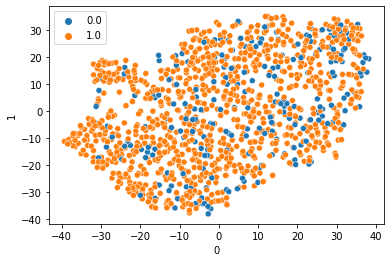

In [50]:
ax = sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)

In [51]:
tsne_model = TSNE(n_components=3)
low_dim_data = tsne_model.fit_transform(tsne_matrix)
print(low_dim_data.shape)

tsne_df = pd.DataFrame(low_dim_data, index=emb_index)
tsne_df.head(5)
print(tsne_matrix)

(1163, 3)
[[-0.03032766  0.34181774  0.0605083  ...  0.00095179  0.17042966
  -0.05516563]
 [-0.03032809  0.34181765  0.06050797 ...  0.00095165  0.17042999
  -0.05516587]
 [-0.03032859  0.34181696  0.06050827 ...  0.00095139  0.17043078
  -0.05516572]
 ...
 [-0.03032879  0.34181726  0.06050734 ...  0.00095156  0.1704302
  -0.05516531]
 [-0.03032856  0.3418175   0.06050722 ...  0.0009519   0.1704299
  -0.05516526]
 [-0.03032848  0.34181777  0.06050832 ...  0.00095138  0.17043024
  -0.05516552]]


In [52]:
import plotly.express as px


fig = px.scatter_3d(
    low_dim_data, x=0, y=1, z=2,
    color=tsne_df.index, labels={'color': 'sentiments'}
)
fig.update_traces(marker_size=8)
fig.show()